In [1]:
import os
# import block
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# tensorflow loads keras lazily, resulting in an IDE bug
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM,StringLookup
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.nn import ctc_loss
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby
from sklearn.model_selection import train_test_split

import random
from pathlib import Path

2024-06-06 07:54:26.008707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 07:54:28.665200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 07:54:30.762421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = Path("/home/arslan/Downloads/Large_Captcha_Dataset")

In [4]:
images = []
gray_images = []
filenames = []
count=0
for filename in os.listdir(data_path):
    if (' ' not in filename) and ('(' not in filename) and (')' not in filename):
        if filename.endswith('.jpg') or filename.endswith('.png') and count != 10000:
            img_path = os.path.join(data_path, filename)
            count+=1
            try:
                with Image.open(img_path) as img:
                    images.append(img_path)
                    # gray_images.append(tf.image.rgb_to_grayscale(img_path))
                    filenames.append(filename)
            except IOError:
                pass

labels = [filename.split('.')[0] for filename in filenames]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
# print(labels)
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  10000
Number of labels found:  10000
Number of unique characters:  62
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
batch_size = 128
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
clip_norm = 1.0

num_epochs = 100
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate
)

img_width = 256
img_height = 80
downsample_factor = 4
max_length = max([len(label) for label in labels])

In [6]:

# mapping characters to integers
# char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
char_to_num = layers.StringLookup(vocabulary=list(characters), num_oov_indices=1, mask_token=None)

# mapping the integers back to the characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
     

2024-06-06 07:55:35.264814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 07:55:35.860520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 07:55:35.861024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# split the dataset up
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
     

## Image Preprocessing and Encoding

In [8]:

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)     # Convert to grayscale
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Get the shape of the image
    shape = tf.shape(img)
    original_height = shape[0]
    original_width = shape[1]

    # Calculate the amount to be cropped or padded
    height_diff = original_height - img_height
    width_diff = original_width - img_width

    # Conditional cropping or padding for height
    if height_diff > 0:  # Crop height
        top_crop = height_diff // 2
        img = tf.image.crop_to_bounding_box(img, top_crop, 0, img_height, original_width)
    else:  # Pad height
        top_pad = tf.abs(height_diff) // 2
        img = tf.image.pad_to_bounding_box(img, top_pad, 0, img_height, original_width)

    # Conditional cropping or padding for width
    if width_diff > 0:  # Crop width
        left_crop = width_diff // 2
        img = tf.image.crop_to_bounding_box(img, 0, left_crop, img_height, img_width)
    else:  # Pad width
        left_pad = tf.abs(width_diff) // 2
        img = tf.image.pad_to_bounding_box(img, 0, left_pad, img_height, img_width)

    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"Image": img, "Label": label}


In [9]:

# def encode_single_sample(img_path, label):
#     img = tf.io.read_file(img_path)
#     img = tf.io.decode_png(img, channels=3)
#     img = tf.image.rgb_to_grayscale(img)     # Convert to grayscale
#     img = tf.image.convert_image_dtype(img, tf.float32)

#     # Get the shape of the image
#     shape = tf.shape(img)
#     original_height = shape[0]
#     original_width = shape[1]

#     # Calculate the amount to be cropped or padded
#     height_diff = original_height - img_height
#     width_diff = original_width - img_width

#     # Conditional cropping or padding for height
#     if height_diff > 0:  # Crop height
#         top_crop = height_diff // 2
#         img = tf.image.crop_to_bounding_box(img, top_crop, 0, img_height, original_width)
#     else:  # Pad height
#         top_pad = tf.abs(height_diff) // 2
#         img = tf.image.pad_to_bounding_box(img, top_pad, 0, img_height, original_width)

#     # Conditional cropping or padding for width
#     if width_diff > 0:  # Crop width
#         left_crop = width_diff // 2
#         img = tf.image.crop_to_bounding_box(img, 0, left_crop, img_height, img_width)
#     else:  # Pad width
#         left_pad = tf.abs(width_diff) // 2
#         img = tf.image.pad_to_bounding_box(img, 0, left_pad, img_height, img_width)

#     img = tf.transpose(img, perm=[1, 0, 2])
    
#     # Pad the label to ensure consistent length
#     label = tf.strings.unicode_split(label, input_encoding="UTF-8")
#     label = tf.pad(label, paddings=[[0, max_length - tf.shape(label)[0]]], constant_values=0)
    
#     # Map characters to integers
#     label = char_to_num(label)
    
#     return {"Image": img, "Label": label}


In [10]:
# Apply augmentation only to the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Test dataset remains the same
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
test_dataset = (
    test_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [11]:
print(len(images_train))
print(len(labels_train))


8000
8000


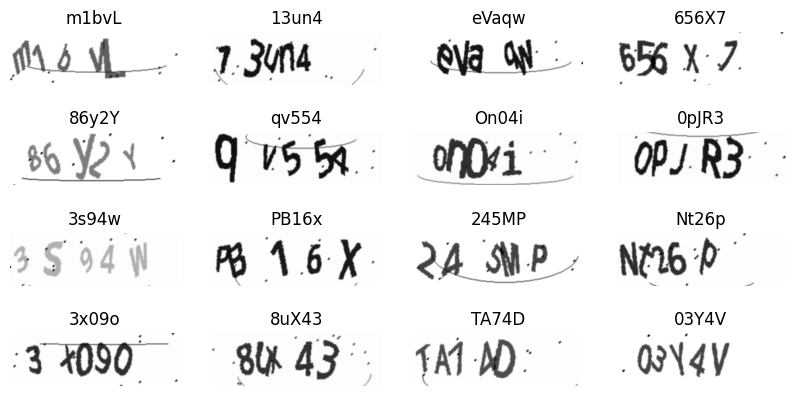

In [12]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
random_batch = next(iter(shuffled_dataset.take(1)))
images = random_batch["Image"]
labels = random_batch["Label"]
for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        img = np.rot90(img, axes=(1,0))
        img = np.fliplr(img)
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [13]:
print(labels)

tf.Tensor(
[[49  2 38 58 22]
 [ 2  4 57 50  5]
 [41 32 37 53 59]
 [ 7  6  7 34  8]
 [ 9  7 61  3 35]
 [53 58  6  6  5]
 [25 50  1  5 45]
 [ 1 52 20 28  4]
 [ 4 55 10  5 59]
 [26 12  2  7 60]
 [ 3  5  6 23 26]
 [24 56  3  7 52]
 [ 4 60  1 10 51]
 [ 9 57 34  5  4]
 [30 11  8  5 14]
 [ 1  4 35  5 32]
 [ 8 18 62  2  2]
 [62 41  2 44 57]
 [29  9 20  7 26]
 [60  1 62  6 48]
 [ 8  7  9 60 12]
 [ 6 29  5 28 10]
 [31 15  1  6  1]
 [ 9 30 14 11 12]
 [54 20  7  9 33]
 [ 7  3 10 62  3]
 [31 26  9 19 24]
 [17 44 34  3 52]
 [ 2  8  1 60 45]
 [20 43  8 20 27]
 [ 3 51 47  4 12]
 [44  2 10 33  9]
 [18 41 53 42 29]
 [10 38 35 10 10]
 [10 11  1 35  5]
 [36 47  3 25 32]
 [57  9  7 49 35]
 [ 1  7  6 39 13]
 [29 36 58 35 60]
 [ 6 39 16 19 61]
 [17 47 41 10  7]
 [20 13 29 10  1]
 [ 1  5 40  3  6]
 [29 27  5 28  8]
 [ 4 48  5 56  7]
 [ 8 50  8 59  4]
 [14  9 39 18 10]
 [ 7 14 16 34  5]
 [ 8  1 55 47 52]
 [16 61  7 47  2]
 [16 10  9 40  1]
 [24  5  8 59 62]
 [ 7 15  5 10  1]
 [ 5 25 59 46 47]
 [51 28 53 44 59]

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [15]:
class CRNN(Model):

  '''
  Convolutional Residual Neural Network

  '''

  def __init__(self):
      super(CRNN, self).__init__()

      # inputs = Input(shape=(32, 128, 1), name="image")
      # labels = layers.Input(name="label", shape=(None,), dtype="float32")

      # Convolution layer 1
      self.conv1 = Conv2D(64, (3, 3), activation = "selu", padding = 'same', name = "Conv1")
      self.pool1 = MaxPool2D(pool_size = (2, 2), strides = 2, name = "MaxPool1")

      # Convlution layer 2
      self.conv2 = Conv2D(128, (3, 3), activation = "selu", padding = 'same', name = "Conv2")
      self.pool2 = MaxPool2D(pool_size = (2, 2), strides = 2, name = "MaxPool2")

      # Convolution layer 3 + 4
      self.conv3 = Conv2D(256, (3, 3), activation = "selu", padding = 'same', name = "Conv3")
      self.conv4 = Conv2D(256, (3, 3), activation = "selu", padding = 'same', name = "Conv4")
      self.pool4 = MaxPool2D(pool_size = (2, 1), strides = 2, name = "MaxPool3")

      # Convolution layer 5
      self.conv5 = Conv2D(512, (3, 3), activation = "selu", padding = 'same', name = "Conv5")
      self.batch_norm5 = BatchNormalization(name = "BatchNormalization1")

      # Convolution layer 6
      self.conv6 = Conv2D(512, (3, 3), activation = "selu", padding = 'same', name = "Conv6")
      self.batch_norm6 = BatchNormalization(name = "BatchNormalization2")
      self.pool6 = MaxPool2D(pool_size = (2, 1), strides = 2, name = "MaxPool4")

      # Convolution layer 7
      self.conv7 = Conv2D(512, (2, 2), activation = "selu", padding = 'valid', name = "Conv7")

      # Map-to-Sequeqnce
      self.dense1 = Dense(512, activation = "selu", name= "Dense1")
      # self.drop = layers.Dropout(0.2)
      self.batch_norm = BatchNormalization(name = "BatchNormalization3")

      # Bidirectional-LSTM
      self.blstm1 = Bidirectional(LSTM(256, return_sequences=True), name = "Bi-LSTM1")
      self.blstm2 = Bidirectional(LSTM(256, return_sequences=True), name = "Bi-LSTM2")

      # Soft-Max
      self.softmax = Dense(len(characters) + 2, activation = 'softmax', name= "Dense2")

      self.CTC = CTCLayer(name = "ctc_loss")


  def call(self, inputs):
    '''
    Forward pass through CRNN

    '''
    image, labels = inputs

    # Convolution Layer 1
    conv1 = self.conv1(image)
    pool1 = self.pool1(conv1)

    # Convolution Layer 2
    conv2 = self.conv2(pool1)
    pool2 = self.pool2(conv2)

    # Convolution Layer 3 + 4
    conv3 = self.conv3(pool2)
    conv4 = self.conv4(conv3)
    pool4 = self.pool4(conv4)

    # Convolution Layer 5
    conv5 = self.conv5(pool4)
    batch_norm5 = self.batch_norm5(conv5)

    # Convolution Layer 6
    conv6 = self.conv6(batch_norm5)
    batch_norm6 = self.batch_norm6(conv6)
    pool6 = self.pool6(batch_norm6)

    # Convolution Layer 7
    conv7 = self.conv7(conv6)

    # Map-to-Sequence
    conv7_shape = conv7.shape
    new_shape = (conv7_shape[1], conv7_shape[2] * conv7_shape[3])  # Adjusted to match the tensor's total size
    reshaped = layers.Reshape(target_shape=new_shape, name= "reshape")(conv7)
    dense1 = self.dense1(reshaped)
    drop1 = self.batch_norm(dense1)

    # Bidirectiona-LSTM
    blstm1 = self.blstm1(drop1)
    blstm2 = self.blstm2(blstm1)

    # Softmax
    softmax_output = self.softmax(blstm2)

    # CTC
    output_logits = self.CTC(labels, softmax_output)
    return output_logits

  def build_model(self):
      inputs = [layers.Input(shape=(img_width, img_height, 1), name="Image", dtype="float32"),
                layers.Input(name="Label", shape=(None,), dtype="float32")]
      outputs = self.call(inputs)
      optimizer = Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, clipnorm=clip_norm)
      model = keras.models.Model(inputs=inputs, outputs=outputs, name="ocr_model_captcha")
      model.compile(optimizer=optimizer)
      return model

In [16]:
ocr_model = CRNN()
model = ocr_model.build_model()

print(model.summary())


Model: "ocr_model_captcha"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image (InputLayer)  │ (None, 256, 80,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 256, 80,   │        640 │ Image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool1            │ (None, 128, 40,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 128, 40,   │     73,856 │ MaxPool1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool2            │ (None, 64, 20,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv2D)      │ (None, 64, 20,    │    295,168 │ MaxPool2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv4 (Conv2D)      │ (None, 64, 20,    │    590,080 │ Conv3[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool3            │ (None, 32, 10,    │          0 │ Conv4[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv5 (Conv2D)      │ (None, 32, 10,    │  1,180,160 │ MaxPool3[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization1 │ (None, 32, 10,    │      2,048 │ Conv5[0][0]       │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv6 (Conv2D)      │ (None, 32, 10,    │  2,359,808 │ BatchNormalizati… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv7 (Conv2D)      │ (None, 31, 9,     │  1,049,088 │ Conv6[0][0]       │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 31, 4608)  │          0 │ Conv7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 31, 512)   │  2,359,808 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization3 │ (None, 31, 512)   │      2,048 │ Dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bi-LSTM1            │ (None, 31, 512)   │  1,574,912 │ BatchNormalizati… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bi-LSTM2            │ (None, 31, 512)   │  1,574,912 │ Bi-LSTM1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,095,360 (42.33 MB)

 Trainable params: 11,093,312 (42.32 MB)

 Non-trainable params: 2,048 (8.00 KB)

None


In [17]:
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    shuffle = True
)

Epoch 1/100


2024-06-06 07:55:43.361412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - loss: 4045.7168 - val_loss: 14067.5586 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - loss: 2528.8235 - val_loss: 3726.4839 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - loss: 2542.8176 - val_loss: 11421.8906 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - loss: 2523.8596 - val_loss: 2496.5020 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - loss: 2522.9978 - val_loss: 2551.0454 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 2522.3665 - val_loss: 2496.2424 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 2522.0032 - val_loss: 13287.8486 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 2521.4954 - val_loss: 16599.1465 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - loss: 25

In [18]:
model.save('my_captcha_model.keras')

## Testing

In [19]:

def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []

    pred_indices = np.argmax(predictions, axis=2) - 1
    # print(pred_indices)

    for i in range(pred_indices.shape[0]):
        ans = ""

        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]

        ## remove blanks
        for p in merged_list:
            if p != len(characters):
                ans += characters[int(p)]

        text_list.append(ans)

    return text_list
     

In [20]:
model.load_weights('my_captcha_model.keras')

In [21]:
# Print the names of all layers in the model
for layer in model.layers:
    print(layer.name)


Image
Conv1
MaxPool1
Conv2
MaxPool2
Conv3
Conv4
MaxPool3
Conv5
BatchNormalization1
Conv6
Conv7
reshape
Dense1
BatchNormalization3
Bi-LSTM1
Bi-LSTM2
Label
Dense2
ctc_loss


In [22]:

model.get_layer(name="Image").input

[]

In [23]:

prediction_model = Model(model.get_layer(name="Image").input, model.get_layer(name="Dense2").output)
prediction_model.summary()

ValueError: `inputs` argument cannot be empty. Received:
inputs=[]
outputs=<KerasTensor shape=(None, 31, 64), dtype=float32, sparse=False, name=keras_tensor_18>

In [ ]:
correct_predictions = 0
total_predictions = 0

for batch in test_dataset:  # Iterate over the entire test dataset
    batch_images = batch["Image"]
    batch_labels = batch["Label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        if pred_texts[i] == orig_texts[i]:
            correct_predictions += 1

    total_predictions += len(pred_texts)


# Calculate overall accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


In [ ]:
for batch in test_dataset.take(1):  # Take one batch
    batch_images = batch["Image"]
    batch_labels = batch["Label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # Plot the images with predictions and original labels
    fig, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):
        if i < len(batch_images):
            img = (batch_images[i] * 255).numpy().astype("uint8")
            img = np.rot90(img)
            img = np.flipud(img)
            title = f"Pred: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap = 'gray')
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
